# Environment

## Imports

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import muon as mu
from muon import atac as ac
import numpy as np

sns.set_theme(style="white")

/lustre/scratch124/cellgen/cellgeni/aljes/peak2vec/.venv/lib/python3.13/site-packages/muon/_core/preproc.py:31: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  if Version(scanpy.__version__) < Version("1.10"):


## Load data

In [2]:
adata = sc.read_h5ad('data/pbmc10k_atac.h5ad')
adata

AnnData object with n_obs × n_vars = 10484 × 364677
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
    layers: 'binary'

In [3]:
adata.obs.head()

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,barcode_rank,total_fragments_count,log10_total_fragments_count,unique_fragments_count,log10_unique_fragments_count,...,fraction_of_fragments_in_peaks,duplication_count,duplication_ratio,nucleosome_signal,tss_enrichment,pdf_values_for_tss_enrichment,pdf_values_for_fraction_of_fragments_in_peaks,pdf_values_for_duplication_ratio,barcode,celltype
obs_names,,,,,,,,,,,,,,,,,,,,,
TATCCAGCATAAGTCT-1___pbmc10k,21728,4.337020,17632,4.246302,pbmc10k,2008,39909,4.601082,27923,4.445978,...,0.739605,11986,0.300333,0.815763,20.598123,0.004664,0.433983,0.363403,TATCCAGCATAAGTCT-1,CLASSICAL_MONOCYTES
TTTGTGAAGGCTACTG-1___pbmc10k,11415,4.057476,9241,3.965719,pbmc10k,8129,21337,4.329154,14211,4.152655,...,0.764619,7126,0.333974,0.695944,26.628792,0.008153,0.836330,1.290391,TTTGTGAAGGCTACTG-1,REGULATORY_T_CELLS
AGAAACCCAGGAACTG-1___pbmc10k,13021,4.114644,10644,4.027105,pbmc10k,7358,23050,4.362690,15644,4.194376,...,0.791102,7406,0.321302,0.646058,25.684892,0.012154,0.787076,1.581555,AGAAACCCAGGAACTG-1,MEMORY_B_CELLS
TAATGGACACCTGGTG-1___pbmc10k,12357,4.091913,9814,3.991846,pbmc10k,7566,23011,4.361954,15311,4.185032,...,0.767879,7700,0.334623,0.636274,31.821768,0.000760,1.016212,1.557395,TAATGGACACCTGGTG-1,TCM_NAIVE_HELPER_T_CELLS
ATCGAGGCATCAGTAT-1___pbmc10k,20002,4.301073,16288,4.211868,pbmc10k,2480,36701,4.564690,25134,4.400279,...,0.760404,11567,0.315169,0.618885,20.101136,0.005371,0.626970,0.843380,ATCGAGGCATCAGTAT-1,CLASSICAL_MONOCYTES


## Helper functions

In [4]:
def compute_peak_counts(adata, chr_num, window_size, step_size):
    start = adata.var[adata.var.Chromosome == chr_num].Start.values
    end = adata.var[adata.var.Chromosome == chr_num].End.values
    mids = (start + end) // 2
    chrom_end = end.max()
    chrom_start = start.min()

    window_starts = np.arange(chrom_start, chrom_end - window_size, step_size)
    window_ends = window_starts + window_size

    mids.sort()
    left = np.searchsorted(mids, window_starts, side="left")
    right = np.searchsorted(mids, window_ends, side="left")  # half-open end
    counts = (right - left).astype(np.int64)
    return window_starts, counts

In [5]:
def peak_distances(adata, chr_num):
    start = adata.var[adata.var.Chromosome == chr_num].Start.values
    end = adata.var[adata.var.Chromosome == chr_num].End.values
    mids = (start + end) // 2
    mids.sort()
    distances = np.diff(mids)
    return distances

# EDA

## Peak statistics

In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Rename columns
adata.obs.rename(
    columns={
        "n_genes_by_counts": "n_features_per_cell",
        "total_counts": "total_fragment_counts",
    },
    inplace=True,
)

# Rename columns
adata.var.rename(
    columns={
        "n_cells_by_counts": "n_cells_per_feature",
    },
    inplace=True,
)

adata

AnnData object with n_obs × n_vars = 10484 × 364677
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

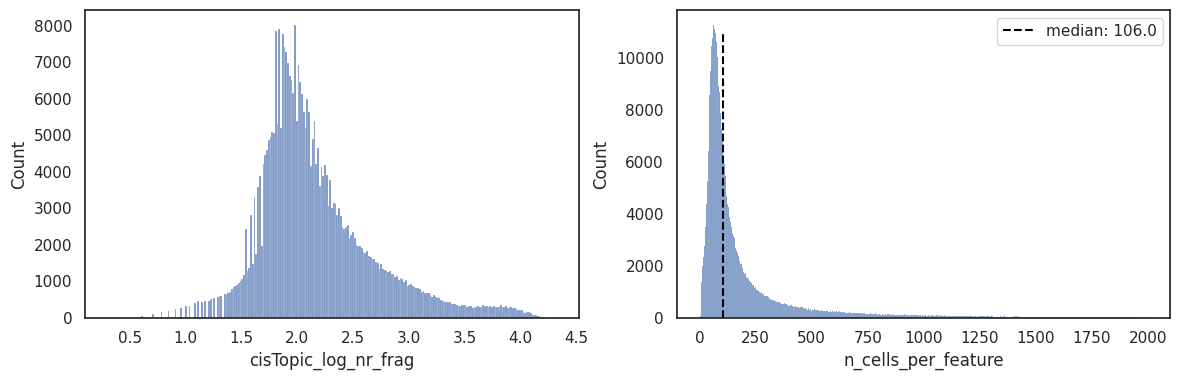

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(adata.var, x="cisTopic_log_nr_frag", ax=ax1)
sns.histplot(adata.var, x="n_cells_per_feature", ax=ax2, binrange=(0, 2000))

median = adata.var["n_cells_per_feature"].median()
ax2.vlines(x=median, ymin=0, ymax=11000, colors="black", linestyles="dashed", label=f"median: {median}")

ax2.legend()
plt.show()

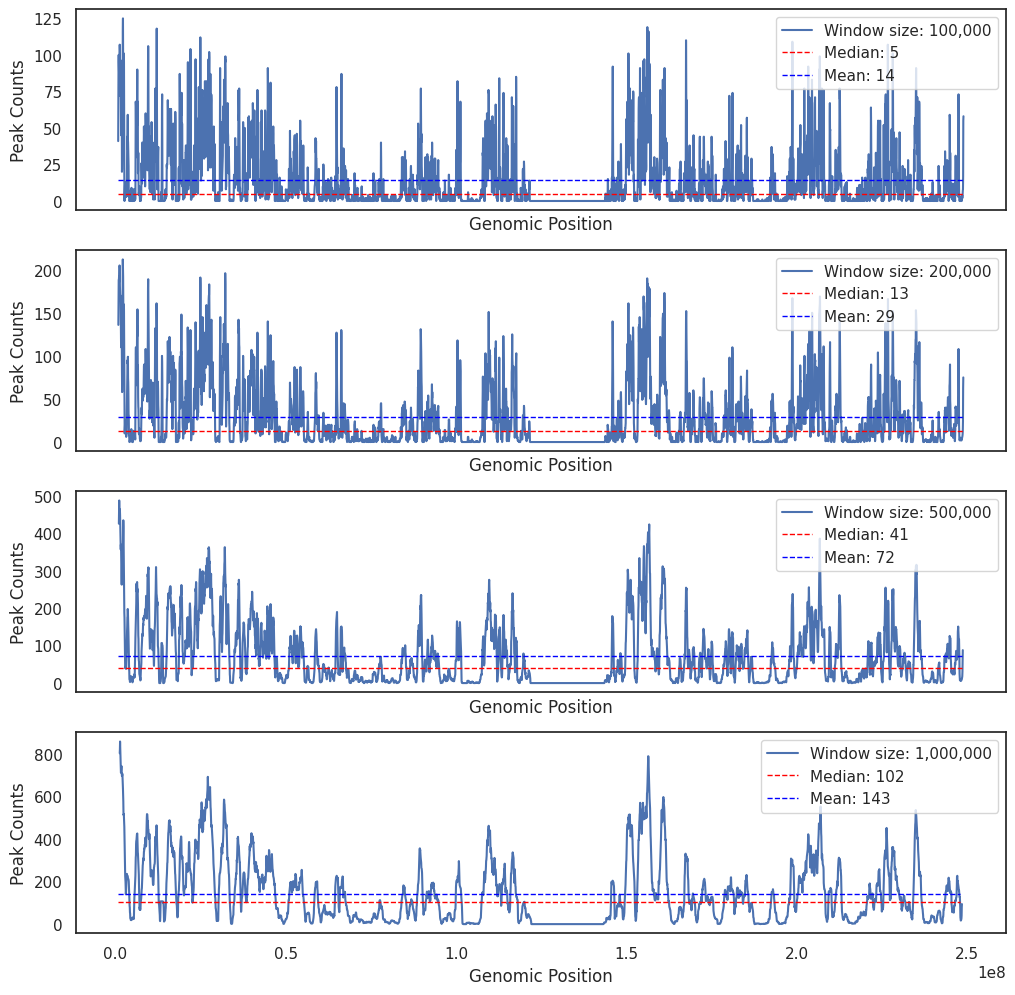

In [8]:
chr_num = "chr1"
step_size = 50_000
window_sizes = [100_000, 200_000, 500_000, 1_000_000]

fig, ax = plt.subplots(
    len(window_sizes), 1, figsize=(12, 3 * len(window_sizes)), sharex=True
)

for ax, window_size in zip(ax.flatten(), window_sizes):
    window_starts, counts = compute_peak_counts(adata, chr_num, window_size, step_size)
    median = np.median(counts)
    mean = np.mean(counts)
    ax.plot(
        window_starts + window_size // 2, counts, label=f"Window size: {window_size:,}"
    )
    ax.hlines(
        median,
        xmin=window_starts.min(),
        xmax=window_starts.max(),
        color="red",
        linestyle="dashed",
        linewidth=1,
        label=f"Median: {median:.0f}",
    )
    ax.hlines(
        mean,
        xmin=window_starts.min(),
        xmax=window_starts.max(),
        color="blue",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {mean:.0f}",
    )
    ax.set_xlabel("Genomic Position")
    # ax.set_title(f"Peak counts on {chr_num} with window size {window_size}")
    ax.set_ylabel("Peak Counts")
    ax.legend()

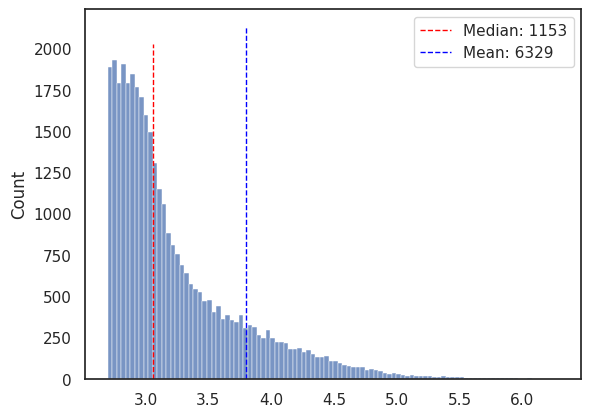

In [9]:
distances = peak_distances(adata, chr_num)
distances = np.delete(distances, distances.argmax()) # remove largest gap
sns.histplot(np.log10(distances), bins=100)

median = np.median(distances)
mean = np.mean(distances)
plt.vlines(np.log10(median), ymin=0, ymax=plt.gca().get_ylim()[1], color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.0f}')
plt.vlines(np.log10(mean), ymin=0, ymax=plt.gca().get_ylim()[1], color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.0f}')
plt.legend()

## Cell statistics

<Axes: xlabel='tss_enrichment', ylabel='Count'>

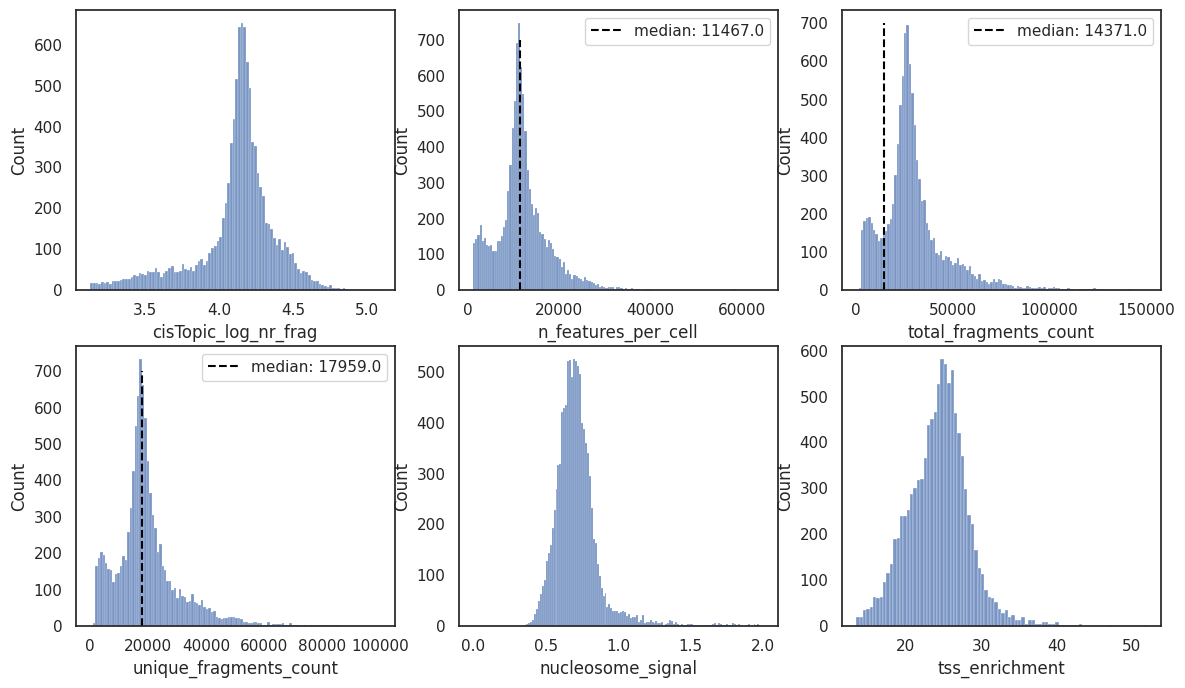

In [10]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.histplot(adata.obs, x="cisTopic_log_nr_frag", ax=ax1)

n_feqatures_median = adata.obs["n_features_per_cell"].median()
sns.histplot(adata.obs, x="n_features_per_cell", ax=ax2)
ax2.vlines(x=n_feqatures_median, ymin=0, ymax=700, colors="black", linestyles="dashed", label=f"median: {n_feqatures_median}")
ax2.legend()

n_fragments_median = adata.obs["total_fragment_counts"].median()
sns.histplot(adata.obs, x="total_fragments_count", ax=ax3, binrange=(0, 150000))
ax3.vlines(x=n_fragments_median, ymin=0, ymax=700, colors="black", linestyles="dashed", label=f"median: {n_fragments_median}")
ax3.legend()

n_unique_fragments_median = adata.obs["unique_fragments_count"].median()
sns.histplot(adata.obs, x="unique_fragments_count", ax=ax4, binrange=(0, 100000))
ax4.vlines(x=n_unique_fragments_median, ymin=0, ymax=700, colors="black", linestyles="dashed", label=f"median: {n_unique_fragments_median}")
ax4.legend()

sns.histplot(adata.obs, x="nucleosome_signal", ax=ax5, binrange=(0, 2))
sns.histplot(adata.obs, x="tss_enrichment", ax=ax6)

## Filter cells and peaks

In [11]:
mu.pp.filter_var(adata, 'n_cells_per_feature', lambda x: (x >= 70) & (x <= 9000))
mu.pp.filter_obs(adata, 'n_features_per_cell', lambda x: (x >= 500) & (x <= 25000))
mu.pp.filter_obs(adata, 'nucleosome_signal', lambda x: x <= 1.3)

In [12]:
adata

AnnData object with n_obs × n_vars = 10006 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

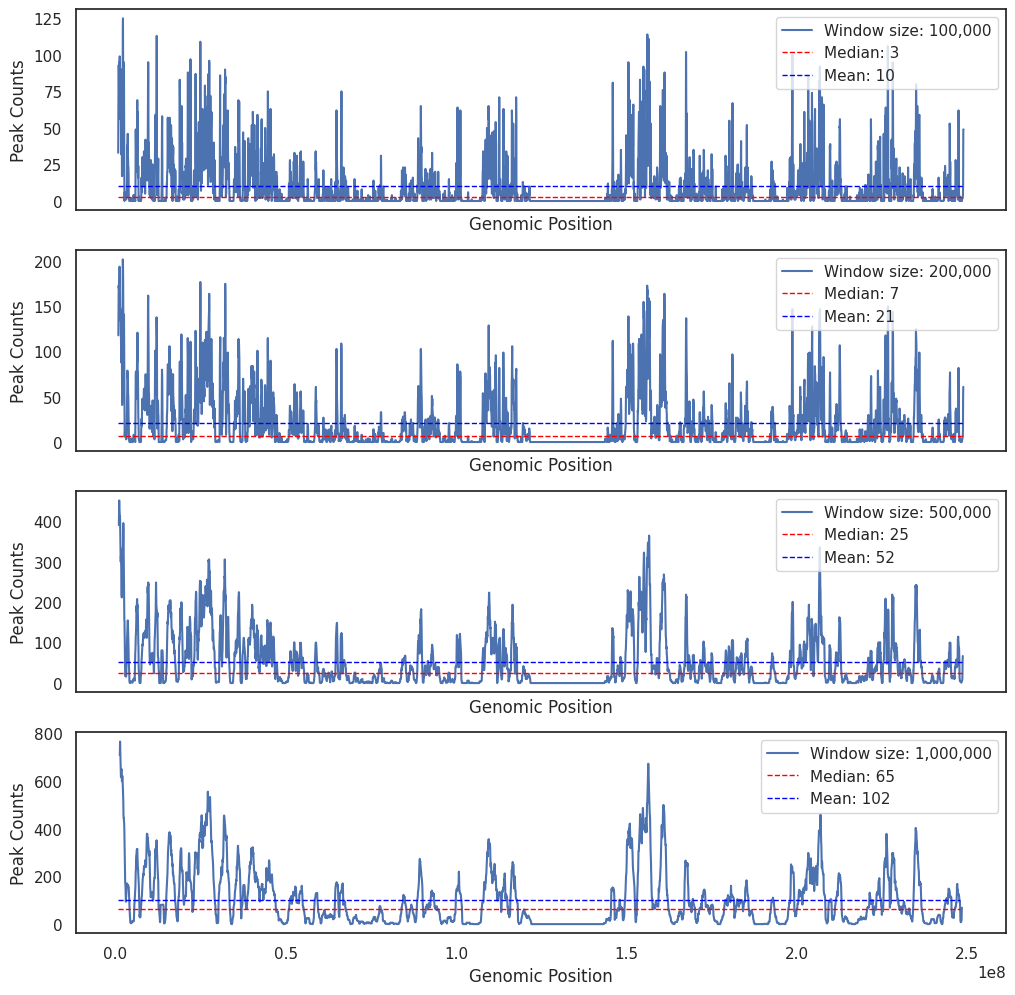

In [13]:
chr_num = "chr1"
step_size = 50_000
window_sizes = [100_000, 200_000, 500_000, 1_000_000]

fig, ax = plt.subplots(
    len(window_sizes), 1, figsize=(12, 3 * len(window_sizes)), sharex=True
)

for ax, window_size in zip(ax.flatten(), window_sizes):
    window_starts, counts = compute_peak_counts(adata, chr_num, window_size, step_size)
    median = np.median(counts)
    mean = np.mean(counts)
    ax.plot(
        window_starts + window_size // 2, counts, label=f"Window size: {window_size:,}"
    )
    ax.hlines(
        median,
        xmin=window_starts.min(),
        xmax=window_starts.max(),
        color="red",
        linestyle="dashed",
        linewidth=1,
        label=f"Median: {median:.0f}",
    )
    ax.hlines(
        mean,
        xmin=window_starts.min(),
        xmax=window_starts.max(),
        color="blue",
        linestyle="dashed",
        linewidth=1,
        label=f"Mean: {mean:.0f}",
    )
    ax.set_xlabel("Genomic Position")
    # ax.set_title(f"Peak counts on {chr_num} with window size {window_size}")
    ax.set_ylabel("Peak Counts")
    ax.legend()

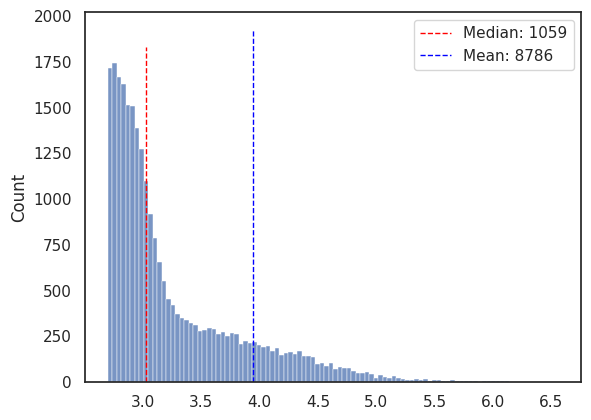

In [14]:
distances = peak_distances(adata, chr_num)
distances = np.delete(distances, distances.argmax()) # remove largest gap
sns.histplot(np.log10(distances), bins=100)

median = np.median(distances)
mean = np.mean(distances)
plt.vlines(np.log10(median), ymin=0, ymax=plt.gca().get_ylim()[1], color='red', linestyle='dashed', linewidth=1, label=f'Median: {median:.0f}')
plt.vlines(np.log10(mean), ymin=0, ymax=plt.gca().get_ylim()[1], color='blue', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.0f}')
plt.legend()

In [15]:
adata.write_h5ad('data/pbmc10k_atac_filtered.h5ad')

## Visualise cells

In [16]:
# Save original counts
adata.layers["counts"] = adata.X.copy()

In [17]:
# Normalize
ac.pp.tfidf(adata, scale_factor=1e4)

In [18]:
# Dimensionality reduction
ac.tl.lsi(adata)

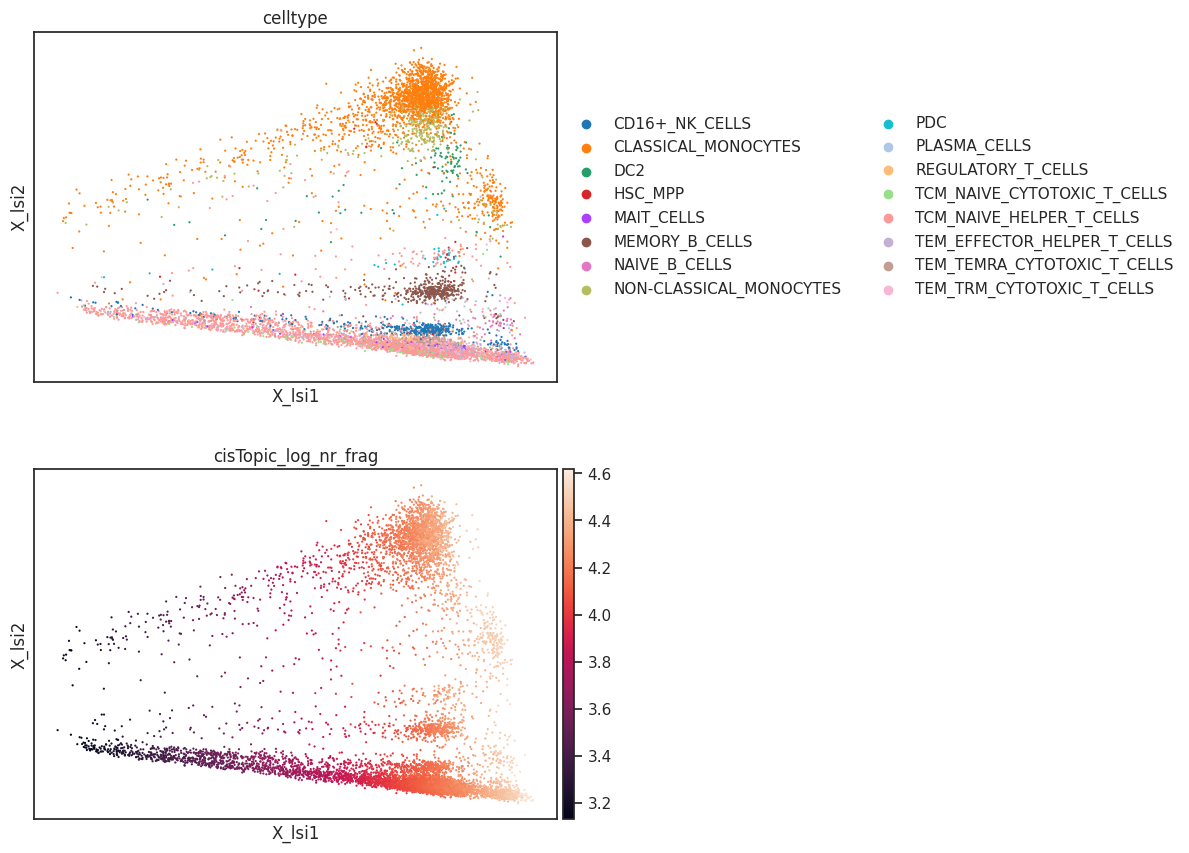

In [19]:
sc.pl.embedding(adata, basis="X_lsi", color=[ "celltype", "cisTopic_log_nr_frag"],  size=10, ncols=1)

In [20]:
# Find neighbors
sc.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [21]:
# Calculate UMAP
sc.tl.umap(adata, random_state=4)

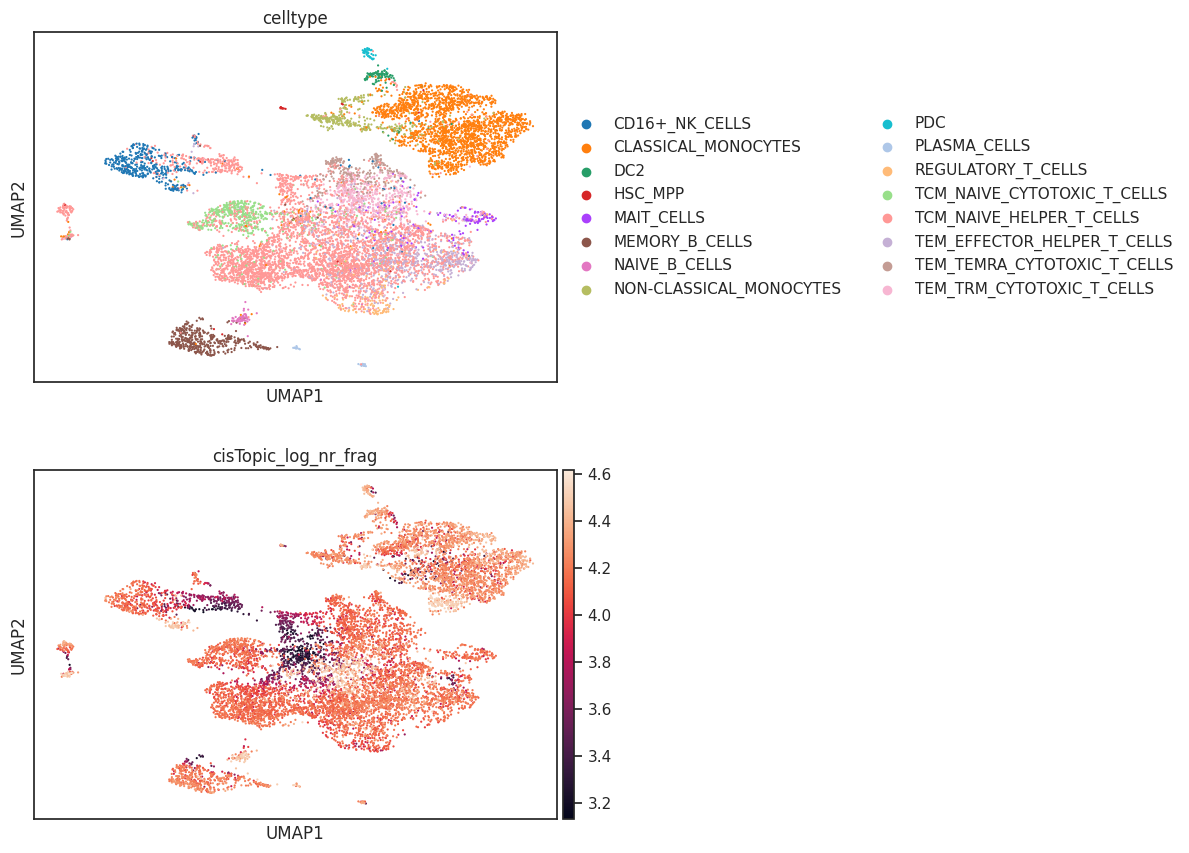

In [22]:
sc.pl.umap(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)

## Visualise peaks

In [23]:
adata_peaks = adata.transpose().copy()
adata_peaks

AnnData object with n_obs × n_vars = 260822 × 10006
    obs: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    var: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    uns: 'lsi', 'celltype_colors', 'neighbors

In [24]:
# Find neighbors
sc.pp.neighbors(adata_peaks, use_rep="LSI", n_neighbors=15, n_pcs=50)

In [25]:
# Calculate clusters
sc.tl.leiden(adata_peaks, resolution=.5, flavor="igraph", n_iterations=2)

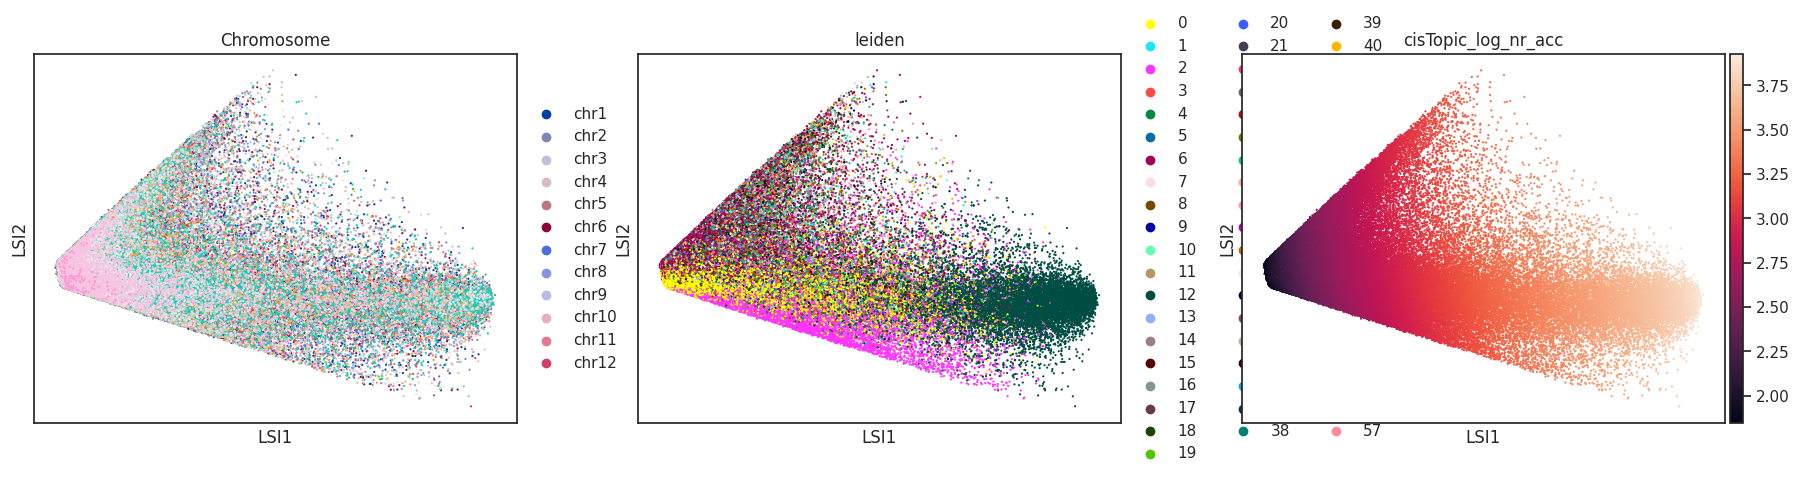

In [26]:
sc.pl.embedding(adata_peaks, basis="LSI", color=["Chromosome", "leiden", "cisTopic_log_nr_acc"],  size=10)

In [27]:
# Calculate UMAP
sc.tl.umap(adata_peaks, random_state=4)

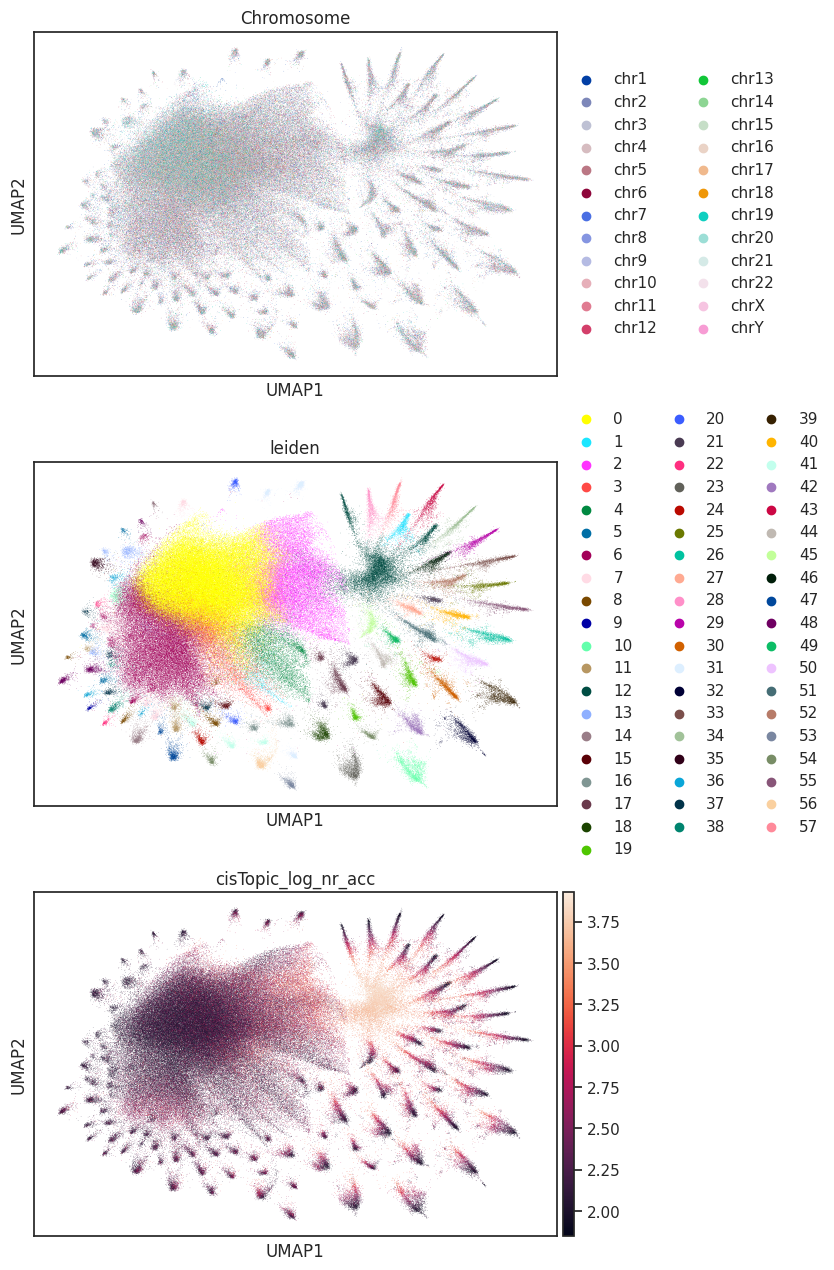

In [28]:
sc.pl.umap(adata_peaks, color=["Chromosome", "leiden", "cisTopic_log_nr_acc"], ncols=1)

In [29]:
adata.write_h5ad('data/pbmc10k_eda.h5ad')